In [30]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as k
from tensorflow.keras.applications import VGG16

In [31]:
train_dir='C:\Lachin\DataSets\Skin cancer ISIC The International Skin Imaging Collaboration\Train'
validation_dir='C:\Lachin\DataSets\Skin cancer ISIC The International Skin Imaging Collaboration\Test'

In [32]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)
train_generator=train_datagen.flow_from_directory(train_dir,target_size=(150,150), batch_size=32,class_mode='categorical')
valid_generator=test_datagen.flow_from_directory(validation_dir, target_size=(150,150),batch_size=32,class_mode='categorical')

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [33]:
conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))

In [34]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [35]:
model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

In [36]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

In [37]:
check_cb=keras.callbacks.ModelCheckpoint("Cancer_BestModel_VGG16.h5", save_best_only=True)#call backs to reduce overfitting
#early_stopcb=keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
#call backs with save best only. Save the model with the lowest validation loss

In [38]:
#model_tp=model.fit_generator(train_generator, steps_per_epoch=2239//32,epochs=50,validation_data=valid_generator,validation_steps=118//32,callbacks=[check_cb,early_stopcb])

In [39]:
model_tp=model.fit_generator(train_generator, steps_per_epoch=2239//32,epochs=10,validation_data=valid_generator,validation_steps=118//32, callbacks=check_cb)

Epoch 1/10
69/69 [==============================] - 640s 9s/step - loss: 2.0634 - accuracy: 0.2373 - val_loss: 1.8991 - val_accuracy: 0.3750
Epoch 2/10
69/69 [==============================] - 634s 9s/step - loss: 1.7167 - accuracy: 0.3888 - val_loss: 2.0928 - val_accuracy: 0.2812
Epoch 3/10
10/69 [===>..........................] - ETA: 9:01 - loss: 1.6343 - accuracy: 0.4219

KeyboardInterrupt: 

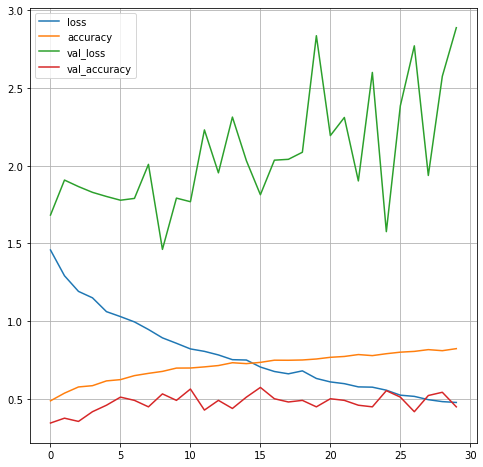

In [47]:
pd.DataFrame(model_tp.history).plot(figsize=(8,8))
plt.grid(True)

In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure